<a href="https://colab.research.google.com/github/klnsuman/DeepLearning/blob/master/SentimentAnalysis_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Oct 12 14:57:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
os.chdir("/content/drive/My Drive/")
df_imdb = pd.read_csv('IMDB_Dataset.csv')


In [10]:
df_imdb.shape

(50000, 2)

In [11]:
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
data_lm = (TextList.from_df(df_imdb)
           #Inputs: all the text files in path
            .split_by_rand_pct(0.20)
           #We randomly split and keep 20% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=128))
data_lm.save('tmp_lm')

In [13]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"this is not a show for the faint hearted or timid . xxmaj this show pulls no punches with regards to drugs , sex or violence . xxmaj its is hardcore , in the classic use of the word . \n \n xxmaj it is called xxup oz as that is the nickname given to the xxmaj oswald xxmaj maximum xxmaj security xxmaj state xxmaj xxunk . xxmaj it"
1,"films , you 've seen them all . xxmaj well made , but certainly xxup not original ! xxmaj and , because it is just a rehash of his other films , anyone giving the film a score of 10 is xxup strongly advised to see these other films . \n \n 4 / 25 / xxup xxunk just checked and saw this this small film was the highest"
2,"watch this movie . xxmaj it may be good for some memorable quotes . xxbos xxmaj what a waste of talent . a very poor , semi - coherent , script cripples this film . xxmaj rather unimaginative direction , too . xxmaj some xxup very faint echoes of _ xxmaj fargo _ here , but it just does n't come off . xxbos xxmaj although it strays away from"
3,"xxmaj jones and xxmaj robert xxmaj duval . xxmaj it was a real stinker and probably the worst movie they were ever in . i think it was a comedy but a not very funny comedy . i really do n't understand why they agreed to be in it "" . xxmaj that would be such an injustice as the original "" xxmaj lonesome xxmaj dove "" was a true"
4,"having been deprived for many years , think she 's the hottest thing to come along since xxmaj granny xxmaj clampett . xxmaj smug science guy and smarmy soldier guy start working together to track the path of the xxmaj mantis , which has devastated some stock footage of an xxmaj eskimo village . xxmaj it comes to the base looking for an after dinner snack , and crushes some"


In [14]:
# Language model AWD_LSTM
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [15]:
print('Model Summary:')
print(learn.layer_groups)

Model Summary:
[Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
), Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
), Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
), Sequential(
  (0): Embedding(47592, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(47592, 400, padding_idx=1)
  )
  (2): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=47592, bias=True)
    (output_dp): RNNDropout()
  )
)]


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 6.92E-03


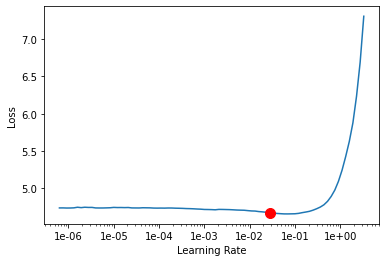

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
learn.fit_one_cycle(1, 1e-2)
learn.save('lm_hyper')

epoch,train_loss,valid_loss,accuracy,time
0,4.147430,3.944580,0.296742,08:02


In [19]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.817075,3.772686,0.317624,09:11


In [20]:
learn.save_encoder('ft_enc')

In [22]:
data_clas = (TextList.from_df(df_imdb, cols=["review"], vocab=data_lm.vocab)
             .split_by_rand_pct(0.20)
             .label_from_df('sentiment')
             .databunch(bs=128))

data_clas.save('tmp_class')

In [21]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

NameError: ignored

In [ ]:
learn.load_encoder('ft_enc')

In [ ]:
learn.freeze_to(-1)
learn.summary()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(1, 1e-3)

In [ ]:
learn.save('stage1')

In [ ]:
learn.load('stage1')
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))
learn.save('stage2')

In [ ]:
from fastai.vision import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [ ]:
interp = TextClassificationInterpretation.from_learner(learn)
interp.show_top_losses(10)

In [ ]:
learn.export()
learn.model_dir = "/kaggle/working"
learn.save("stage-1",return_path=True)